<a href="https://colab.research.google.com/github/pabloswfly/mcmcgan/blob/master/Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that we have learn to do demographic simulations with msprime, we can start building our discriminator with the permutation invariance property. The discriminator in the beginning will tell apart simulations with different recombination rate, between 1e-7 and 1e-10. We first simulate the data.

In [0]:
# Installing required libraries
!apt-get install python-dev libgsl0-dev
!python3 -m pip install msprime

In [0]:
# Importing libraries and modules
import msprime
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, BatchNormalization, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [0]:
def fixed_size_geno(ts, x):
  """Returns a genotype matrix with a fixed number of columns, as specified in x"""

    m = np.zeros((ts.num_samples, x), dtype=float)

    for variant in ts.variants():
        j = int(variant.site.position * x / ts.sequence_length)
        m[:, j] += variant.genotypes

    return m



def scale_matrix(m):
  """Scale matrix values to [-1, 1] range"""

  maxim = np.max(m)
  return (m*2/maxim - 1)



def simulate_data(samples, n_reps, fixed_size, recomb_rate, seed, scale=True):
  """Simulate demographic data, returning a tensor with n_reps number of genotype matrices"""

  sims = msprime.simulate(sample_size=samples, Ne=10000, length=1e5, mutation_rate=1e-8, 
              recombination_rate=recomb_rate, num_replicates=n_reps, random_seed=seed)


  mat = np.zeros((n_reps, samples, fixed_size))

  # For each tree sequence output from the simulation
  for i, treeseq in enumerate(sims):

    mat[i] = fixed_size_geno(treeseq, fixed_size)

  # Scale genotype matrices from [0, 1] to [-1, 1].
  # If we were to use a generator, this scale should be done with tanh function
  if scale:
    mat = scale_matrix(mat)

  # Expand dimension by 1 (add channel dim). -1 stands for last axis.
  mat = np.expand_dims(mat, axis=-1)

  return mat

In [143]:
#Generate (X, y) data from demographic simulations
n_reps = 1500
samples = 100
matrix_cols = 128
gen0 = simulate_data(samples, n_reps, matrix_cols, 1e-7, 31415)
gen1 = simulate_data(samples, n_reps, matrix_cols, 1e-10, 27182)
X = np.concatenate((gen0, gen1))
y = np.concatenate((np.zeros((n_reps)), np.ones((n_reps))))

print(X.shape)

#Split randomly into training and test data.
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)

(3000, 100, 128, 1)


The genotype data X contains the segregating sites (SNPs) from the two simulated scenarios, which are labelled accordingly in y.  For each independent simulation, the genotype matrix has shape (samples, matrix_cols). X contains 3000 data entries, 1500 from each class, and divided into 2.400 training data and 600 testing data. The labels are 0 for recombination rate of 1e-7 and 1 for 1e-10.

We are going to visualize a genotype matrix from each different scenario as an image with matplotlib:

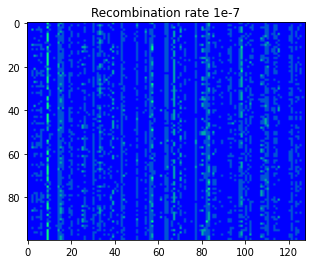

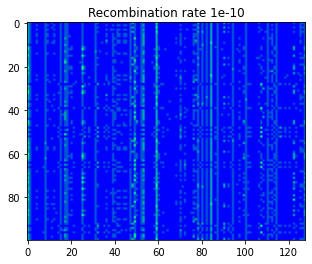

In [149]:
plt.imshow(np.squeeze(gen0[0]), cmap="winter")
plt.title("Recombination rate 1e-7")
plt.savefig("genomat_rr7.png")
plt.show()
plt.imshow(np.squeeze(gen1[0]), cmap="winter")
plt.title("Recombination rate 1e-10")
plt.savefig("genomat_rr10.png")
plt.show()

Now we will build the discriminator with the permutation invariance property. The Symmetric layer class is a type of layer that applies a summary statistics throughout the selected axis in the input tensor, and collapses that axis dimension to 1 in the output tensor. Different summary statistics can be chosen, such as 'max', 'min', 'sum' and 'mean'.

In [0]:
class Symmetric(Layer):

    def __init__(self, function, axis, **kwargs):
      self.function = function
      self.axis = axis
      super(Symmetric, self).__init__(**kwargs)

    def call(self, x):
      if self.function == 'sum':
        out = K.sum(x, axis=self.axis, keepdims=True)
      if self.function == 'mean':
        out = K.mean(x, axis=self.axis, keepdims=True)
      if self.function == 'min':
        out = K.min(x, axis=self.axis, keepdims=True)
      if self.function == 'max':
        out = K.max(x, axis=self.axis, keepdims=True)
      return out

In order to allow permutation invariance, the convolutional kernels have a dimension of 1xN (where N=6 at the moment). Also, instead of using pooling layers for downsampling, strides of (1,2) are used, so the number of different rows/haplotypes remains intact, but the sequence length is halved at that Conv2d layer.
Following successful GANs tips, the network also includes Dropout, Batch Normalization and LeakyReLU activation.

In [0]:
def build_discriminator():

    cnn = Sequential()

    # None in input_shape for dimensions with variable size.
    cnn.add(Conv2D(filters=16, kernel_size=(1, 6), padding='same', strides=(1, 1), input_shape=(100, 128, 1)))
    cnn.add(LeakyReLU(0.3))
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(filters=32, kernel_size=(1, 6), padding='same', strides=(1, 2)))
    cnn.add(LeakyReLU(0.3))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.3))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(Conv2D(filters=64, kernel_size=(1, 6), padding='same', strides=(1, 2)))
    cnn.add(LeakyReLU(0.3))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.3))

    cnn.add(Symmetric('mean', axis=2))

    cnn.add(Flatten())
    cnn.add(Dense(1, activation='sigmoid'))

    return cnn

Compiling and training the discriminator:

In [147]:
#Bbuild the discriminator
print('Discriminator model:')
discriminator = build_discriminator_5()
discriminator.summary()
discriminator.compile(
    optimizer=Adam(learning_rate=0.0001, beta_1=0.5),
    loss=['binary_crossentropy'],
    metrics = ['accuracy']
)

training = discriminator.fit(xtrain, ytrain, batch_size=32, epochs=20, validation_split=0.2, shuffle=False)

Discriminator model:
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_165 (Conv2D)          (None, 100, 128, 16)      112       
_________________________________________________________________
leaky_re_lu_165 (LeakyReLU)  (None, 100, 128, 16)      0         
_________________________________________________________________
batch_normalization_165 (Bat (None, 100, 128, 16)      64        
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 100, 64, 32)       3104      
_________________________________________________________________
leaky_re_lu_166 (LeakyReLU)  (None, 100, 64, 32)       0         
_________________________________________________________________
batch_normalization_166 (Bat (None, 100, 64, 32)       128       
_________________________________________________________________
dropout_110 (Dropout)        (No

In [139]:
discriminator.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 100, 150, 16)      112       
_________________________________________________________________
leaky_re_lu_159 (LeakyReLU)  (None, 100, 150, 16)      0         
_________________________________________________________________
batch_normalization_159 (Bat (None, 100, 150, 16)      64        
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 100, 75, 32)       3104      
_________________________________________________________________
leaky_re_lu_160 (LeakyReLU)  (None, 100, 75, 32)       0         
_________________________________________________________________
batch_normalization_160 (Bat (None, 100, 75, 32)       128       
_________________________________________________________________
dropout_106 (Dropout)        (None, 100, 75, 32)     

Code to test the permutation invariance property of the network. The resulting test error is the same, independently of the shuffling of the haplotype order in the input genotype matrices. It is possible to graphically check this. The three plotted images belong to the same genotype matrices, but with a different permutation of the individual haplotypes (rows).

600/600 [==============================] - 3s 5ms/sample - loss: 0.3391 - acc: 0.8433


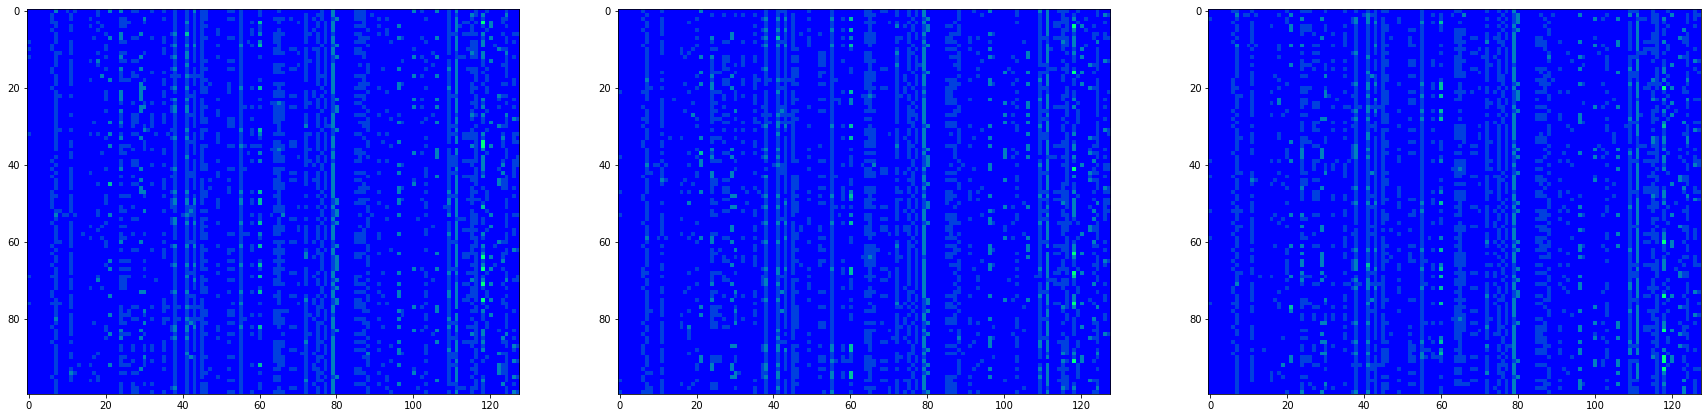

In [151]:
def test_permutation_invariance(model, x, y):

  plt.figure(figsize=(30,45))

  for i in range(1, 4):

    for img in x:
      np.random.shuffle(img)

    model.evaluate(x, y, batch_size=32)
    plt.subplot(1, 3, i)
    plt.imshow(np.squeeze(x[0]), cmap="winter")

  plt.savefig("test.png")
  plt.show()


test_permutation_invariance(discriminator, xtest, ytest)

Some graphical results:

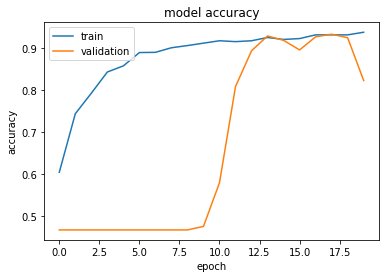

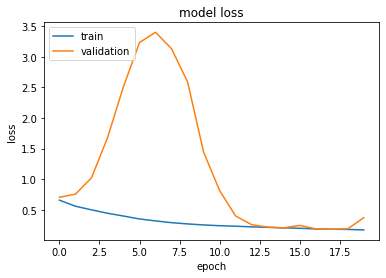

In [150]:
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('accuracy_model.png')
plt.show()

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_model.png')
plt.show()

Some draft code which might be helpful later:

In [0]:
# Debug the input and output of certain selected layers from the model
fun = K.function([model.layers[7].input], [model.layers[7].output])
fun2 = K.function([model.layers[12].input], [model.layers[12].output])

# Output
output = fun([toy])[0]
out = fun2([output])[0]

print(out)